### Import Libraries

In [11]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import hsmm_mvpy as hmp
from pathlib import Path
from mne.io import read_info
from hmpai.data import StageFinder, SAT1_STAGES_ACCURACY, SAT1_STAGES_SPEED, SAT2_STAGES_ACCURACY, SAT2_STAGES_SPEED, AR_STAGES
import scipy
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
data = xr.load_dataset(Path("../data/ar/data.nc"))

In [13]:
cpus = 12

epoched_data_path = Path("../data/ar/data.nc")
output_path = Path("../data/ar/stage_data.nc")
labels = AR_STAGES

stage_finder = StageFinder(
    epoched_data_path,
    labels,
    cpus=cpus,
    fit_function="fit_single",
    fit_args={"starting_points": 10},
)
stage_finder.fit_model()

Transforming epoched data to principal component (PC) space
Fitting HMP model
Estimating 5 events model with 10 starting point(s)


  0%|          | 0/10 [00:00<?, ?it/s]

parameters estimated for 5 events model


In [14]:
channel_data = scipy.io.loadmat(Path("../data/ar/chanlocs.mat"))
channels = [channel_data["chanlocs"][0][i][0][0] for i in range(32)]
channels
# Create new channel ordering to adhere as close as possible to SAT 1 ordering
reindex_channels = channels.copy()
reindex_channels[1] = "FP2"
reindex_channels[2] = "FPZ"
reindex_channels[8:13] = channels[13:18]
reindex_channels[13:18] = channels[23:28]
reindex_channels[18:19] = ["O1", "O2"]
reindex_channels[20:25] = ["FC3", "FCZ", "FC4", "FT7", "FT8"]
reindex_channels[25:30] = channels[18:23]
reindex_channels[30:33] = ["trash1", "trash2"]

In [15]:
positions = np.empty((30, 2), dtype=np.float32)
pos_dict = {}
for channel in channel_data["chanlocs"][0]:
    # print(channel)
    ch_name = channel[0][0]
    ch_x = -(channel[5][0].item() / 1000)
    ch_y = channel[4][0].item() / 1000
    pos_dict[ch_name] = (ch_x, ch_y)
for i, ch in enumerate(reindex_channels):
    if ch == "trash1" or ch == "trash2":
        continue
    positions[i] = pos_dict[ch]

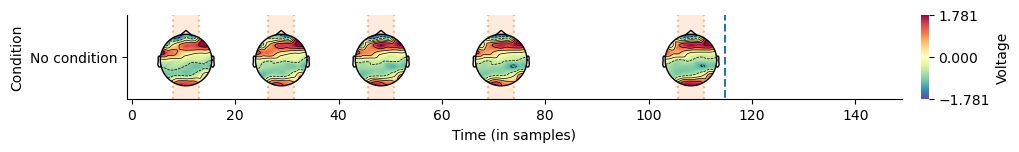

In [16]:
# Visualize model to check if fitting was done as expected
stage_finder.visualize_model(positions)

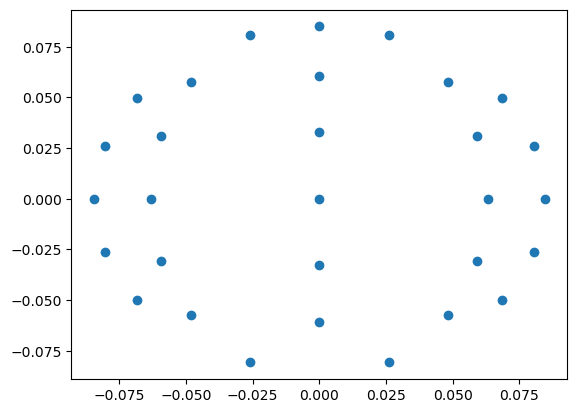

In [151]:
plt.scatter(positions[:, 0], positions[:, 1])

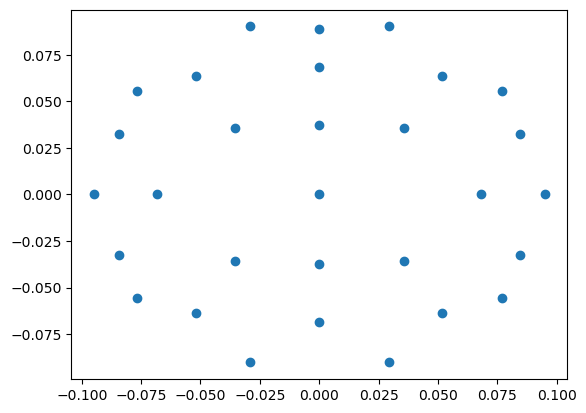

In [124]:
mne_info = read_info(Path("../data/sat1/preprocessed/processed_0001_epo.fif"))
mne_positions = np.empty((30, 2))
for i, pos in enumerate(mne_info["chs"]):
    # print(pos["ch_name"])
    # print(pos["loc"])
    mne_positions[i] = pos["loc"][[0, 1]]
plt.scatter(mne_positions[:, 0], mne_positions[:, 1])

In [122]:
positions

array([[-2.6133014e-02,  8.0784015e-02],
       [ 2.6133014e-02,  8.0784015e-02],
       [-0.0000000e+00,  8.4981233e-02],
       [-6.8423338e-02,  4.9871378e-02],
       [-4.8200428e-02,  5.7551064e-02],
       [-0.0000000e+00,  6.0738482e-02],
       [ 4.8142597e-02,  5.7584025e-02],
       [ 6.8383589e-02,  4.9926527e-02],
       [-8.4538542e-02,  5.1764926e-18],
       [-6.3171282e-02,  3.8681253e-18],
       [-0.0000000e+00,  5.2047490e-18],
       [ 6.3167311e-02,  3.8678821e-18],
       [ 8.4538542e-02,  5.1764926e-18],
       [-6.8423338e-02, -4.9871378e-02],
       [-4.8200428e-02, -5.7551064e-02],
       [ 7.4383183e-18, -6.0738482e-02],
       [ 4.8142597e-02, -5.7584025e-02],
       [ 6.8383589e-02, -4.9926527e-02],
       [-2.6133014e-02, -8.0784015e-02],
       [ 2.6133014e-02, -8.0784015e-02],
       [-5.9274979e-02,  3.0955285e-02],
       [-0.0000000e+00,  3.2927882e-02],
       [ 5.9274979e-02,  3.0955285e-02],
       [-8.0410011e-02,  2.6207503e-02],
       [ 8.04100

In [125]:
mne_positions

array([[-2.93387305e-02,  9.02953297e-02],
       [ 2.93387305e-02,  9.02953297e-02],
       [ 5.43070501e-18,  8.86901394e-02],
       [-7.68097937e-02,  5.58055826e-02],
       [-5.17757088e-02,  6.39376715e-02],
       [ 4.18445153e-18,  6.83372840e-02],
       [ 5.17757088e-02,  6.39376715e-02],
       [ 7.68097937e-02,  5.58055826e-02],
       [-9.49421301e-02, -5.81352874e-18],
       [-6.83372840e-02, -4.18445153e-18],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 6.83372840e-02,  4.18445153e-18],
       [ 9.49421301e-02,  5.81352874e-18],
       [-7.68097937e-02, -5.58055826e-02],
       [-5.17757088e-02, -6.39376715e-02],
       [ 4.18445153e-18, -6.83372840e-02],
       [ 5.17757088e-02, -6.39376715e-02],
       [ 7.68097937e-02, -5.58055826e-02],
       [-2.93387305e-02, -9.02953297e-02],
       [ 2.93387305e-02, -9.02953297e-02],
       [-3.55974026e-02,  3.55974026e-02],
       [ 2.27291117e-18,  3.71194556e-02],
       [ 3.55974026e-02,  3.55974026e-02],
       [-8.